NOTE:  If you get error messages like `IOPub message rate exceeded.` while running this notebook, close your Jupyter instance and restart it adding the option `--NotebookApp.iopub_data_rate_limit=1.0e10`.  (As instructed [here](https://stackoverflow.com/a/44679222)).  Also try `--NotebookApp.iopub_msg_rate_limit=1.0e10`.

# Monte Carlo Method

In this assignment you will implement on-policy every-visit Monte Carlo Control and off-policy every-visit Monte Carlo Control with Weighted Importance Sampling. You will apply both of these algorithms on the frozen lake and blackjack environments and visualize their performance.

In [2]:
import copy
import itertools as itt
from collections import defaultdict
from queue import deque

import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from gym.envs.toy_text.blackjack import BlackjackEnv
from gym.envs.toy_text.frozen_lake import FrozenLakeEnv
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('ggplot')

### Setup the Environment

This assignment uses two OpenAI gym environments: the frozen lake environment and the blackjack environment. Frozen lake is a grid world where the agent must reach a goal state while avoiding holes. You can get the full description of frozen lake [here](https://gym.openai.com/envs/FrozenLake-v0/), and the full description of blackjack [here](https://gym.openai.com/envs/Blackjack-v0/).  The blackjack implementation is the same as described in Example 5.1 in [SB](http://incompleteideas.net/book/the-book-2nd.html).

In [3]:
env_blackjack = BlackjackEnv()
env_frozen_lake = FrozenLakeEnv(desc=None, map_name="4x4", is_slippery=False)

### Exercise 1 (5 pts):

Implement e-greedy action selection based on the current Q-values. Break ties between equal Q-values randomly. Remember an action should be a number in the range: [0, num_actions - 1].

In [4]:
def select_action_epsilon_greedy(Q_array, *, eps):
    """Perform epsilon greedy action selection based on the Q-values.
    
    Args:
        Q_array: A numpy array that contains Q-values relative to a single state.
        eps: The probability to select a random action. Float between 0 and 1.
    
    Returns:
        The selected action as an integer.
        
    Shapes:
        Q_array: `(A,)` where `A` is the number of actions.
        output: Scalar.
    """
    assert Q_array.ndim == 1
    
    random_num = np.random.rand()    
   
    # Take the greedy action
    if (random_num > eps):
        action = np.random.choice(np.flatnonzero(Q_array == Q_array.max()))
    # Choose a random action from valid actions
    else:
        action = np.random.randint(0, len(Q_array)) 
                
    return action 

In [5]:
def sample_episode(env, Q, *, eps):
    """Sample an episode from the environment, using an epsilon-greedy policy based on Q.
    
    Args:
        env: The environment from which to sample episodes.
        Q: A dictionary mapping state -> action values array.
        eps: The epsilon-greedy parameter.
    
    Returns:
        transitions: A list of (state, action, reward) tuples describing the episode.
        
    Shapes:
        Q: `(A,)` Each value in Q is an array with shape `(A,)` where `A` is the number of actions.
    """
    transitions = []  # store (state, action, reward) tuples here

    # NOTE:  sample an episode and store it in the transitions list.
    # NOTE: the Gym interface will require you to use the following methods
    # state = env.reset()  # initialize environment and get initial state
    # state_next, reward, done, info = env.step(action)  # perform action and receive next state, reward, done flag, and additional information.
    
    state = env.reset()
    done = False
    transitions = []
    
    while (not done):
        action = select_action_epsilon_greedy(Q[state], eps=eps)
        state_next, reward, done, info = env.step(action)
        transitions.append((state, action, reward))
        state = state_next
        
    return transitions

### On-policy every-visit Monte Carlo:

Implement the on-policy every-visit Monte Carlo update using the incremental update formula in Section 2.3 in SB. Recall that in Chapter 2 we averaged the *rewards* whereas in MC we average the *returns*. In the formula below $G_n$ denotes the return at timestep $n$.

$$
\begin{equation}
    Q_{n+1} = Q_n + \alpha_n [G_n - Q_n]
\end{equation}
$$

In [11]:
def on_policy_every_visit_mc_control(env, num_episodes, *, eps, gamma):
    """Train an on-policy every-visit MC agent.
    
    Args:
        env: The environment to train the agent on.
        num_episodes: The number of episodes to train the agent for.
        eps: The probability to select a random action. Float between 0.0 and 1.0.     
        gamma: The discount factor.
        
    Returns:
        Q: a dictionary mapping state -> action values array.
        returns: an array containing the returns obtained for each episode during training.
    
    Shapes:
        Q: `(A,)` Each value in Q is an array with shape `(A,)` where `A` is the number of actions.
        returns: `(E,)` where E is the number of episodes we are using to train the agent.
    """
    
    # NOTE:  The pseudo-code in the book explicitly stores lists of returns for each (s,a) pair.
    # We want to be more memory-efficient;  so we will store counts `C` for each (s,a) pair, and use
    # the update rule in SB 2.3 to compute the same average, without having to store all the returns.

    # Create Q function dict with default values, and C (the counts) dict with default values
    Q = defaultdict(lambda: np.zeros([env.action_space.n]))
    C = defaultdict(lambda: np.zeros([env.action_space.n], dtype=np.int))
    len_episode = []

    G_queue = deque(maxlen=100)  # stores 100 most recent episode returns for diagnostics
    
    # Returns array to store episode performances
    returns = np.empty(num_episodes)

    pbar = tqdm.tnrange(num_episodes, leave=False)  # progress bar
    for i in pbar:
        G = 0.0
        
        # YOUR CODE HERE:  sample an episode, and use the transition list to compute returns and update Q and C.
        episode = sample_episode(env, Q, eps=eps)
        T = len(episode)
              
        for step in reversed(range(T)):
            (state, action, reward) = episode[step]
            G = gamma * G + reward
                                              
            # Update C
            C[state][action] += 1
        
            # Update Q
            old_Q = Q[state][action]
            Q[state][action] = old_Q + 1/C[state][action] * (G - old_Q)
            
        returns[i] = G
            
        # diagnostics
        G_queue.append(G)
        pbar.set_description('Episodes G={}'.format(sum(G_queue) / len(G_queue)))
        
    return Q, returns

### Learning Curves:

a)  Calculate the learning curve (or returns) for the frozen lake environment, averaged over 50 independent runs and 1k episodes each, using $\gamma = 1.0$ and $\epsilon = 0.5$.

In [12]:
num_runs, num_episodes = 50, 1000
returns_fl = np.empty((num_runs, num_episodes))

for i in tqdm.tnrange(num_runs, desc='Runs'):
    gamma = 1.0
    eps = 0.5
    (Q, returns) = on_policy_every_visit_mc_control(env_frozen_lake, num_episodes, eps=eps, gamma=gamma)
    returns_fl[i] = returns
learning_curve = returns_fl.mean(axis=0)     

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



b) (3 pts) Plot the resulting learning curve, averaging over the 50 runs, for the frozen lake environment.  If the results are noisy, use the following function to also plot, in the same figure, a smoother version of the same data.  Use these plots as a basis to find a better $\epsilon$ parameter, which makes the performance converge better.

In [13]:
def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rollin average.
    
    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window
        
    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(np.ones_like(data), kernel)
    return smooth_data[: -window_size + 1]

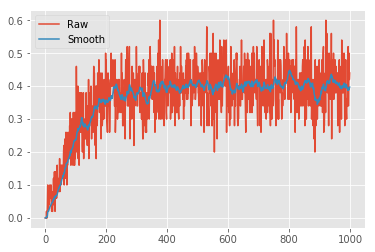

In [14]:
# YOUR CODE HERE
smooth_data = rolling_average(learning_curve, window_size = 20)
plt.plot(learning_curve, label='Raw')
plt.plot(smooth_data, label='Smooth')
plt.legend()

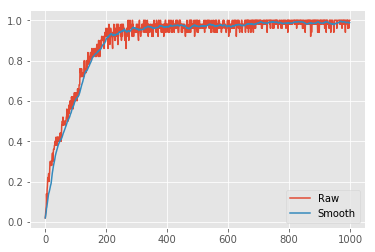

In [16]:
# Best epsilon found: 0.01
returns_fl = np.zeros((num_runs, num_episodes))
eps = 0.01
for j in tqdm.tnrange(num_runs, desc='Epsilon = {}'.format(eps)):
    gamma = 1.0
    (Q, returns) = on_policy_every_visit_mc_control(env_frozen_lake, num_episodes, eps=eps, gamma=gamma)
    returns_fl[j] = returns
learning_curve = returns_fl.mean(axis=0) 
    
# Plot 
smooth_data = rolling_average(learning_curve, window_size = 20)
plt.plot(learning_curve, label='Raw')
plt.plot(smooth_data, label='Smooth')
plt.legend()

c) (5 pts) Compute and plot the learning curve for the blackjack environment, this time averaging 50 runs of 5k episodes each.  Again, start with $\epsilon = 0.5$, and use the resulting plots to find a better $\epsilon$ with better convergence.

In [ ]:
num_runs, num_episodes = 50, 5000
returns_bj = np.empty((num_runs, num_episodes))

for i in tqdm.tnrange(num_runs, desc='Runs'):
    # YOUR CODE HERE
    eps = 0.5
    (Q, returns) = on_policy_every_visit_mc_control(env_blackjack, num_episodes, eps=eps, gamma=1.0)
    returns_bj[i] = returns
learning_curve_e = returns_bj.mean(axis=0)  

smooth_data_e = rolling_average(learning_curve_e, window_size = 50)
plt.plot(smooth_data_e, label='epsilon = 0.5')
plt.legend()

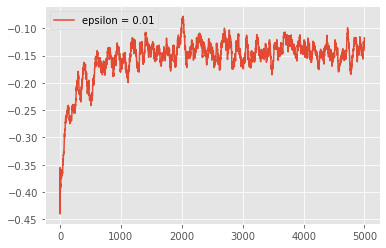

In [12]:
# YOUR CODE HERE
# Best epsilon found: 0.01
num_runs, num_episodes = 50, 5_000
returns_bj = np.zeros((num_runs, num_episodes))
eps = 0.01
for j in tqdm.tnrange(num_runs, desc=f'Epsilon = {eps}'):
    (Q, returns) = on_policy_every_visit_mc_control(env_blackjack, num_episodes, eps=eps, gamma=1.0)
    returns_bj[j] = returns
learning_curve = returns_bj.mean(axis=0) 
    
# Plot two choices of epsilon
smooth_data = rolling_average(learning_curve, window_size = 50)
plt.plot(smooth_data, label='epsilon = 0.01')
plt.legend()

### Exercise 4 (10 pts):

Run your code up to 500k episodes for the blackjack domain with a step size parameter that enables the value function to converge. Plot the value function as a color plot with a similar layout to that shown in SB Figure 5.2.  If convenient, use the given `plot_surface` function, creates a 3D plot given matrices X and Y representing the 2D function domain, and matrix Z representing the function value at those domain inputs.

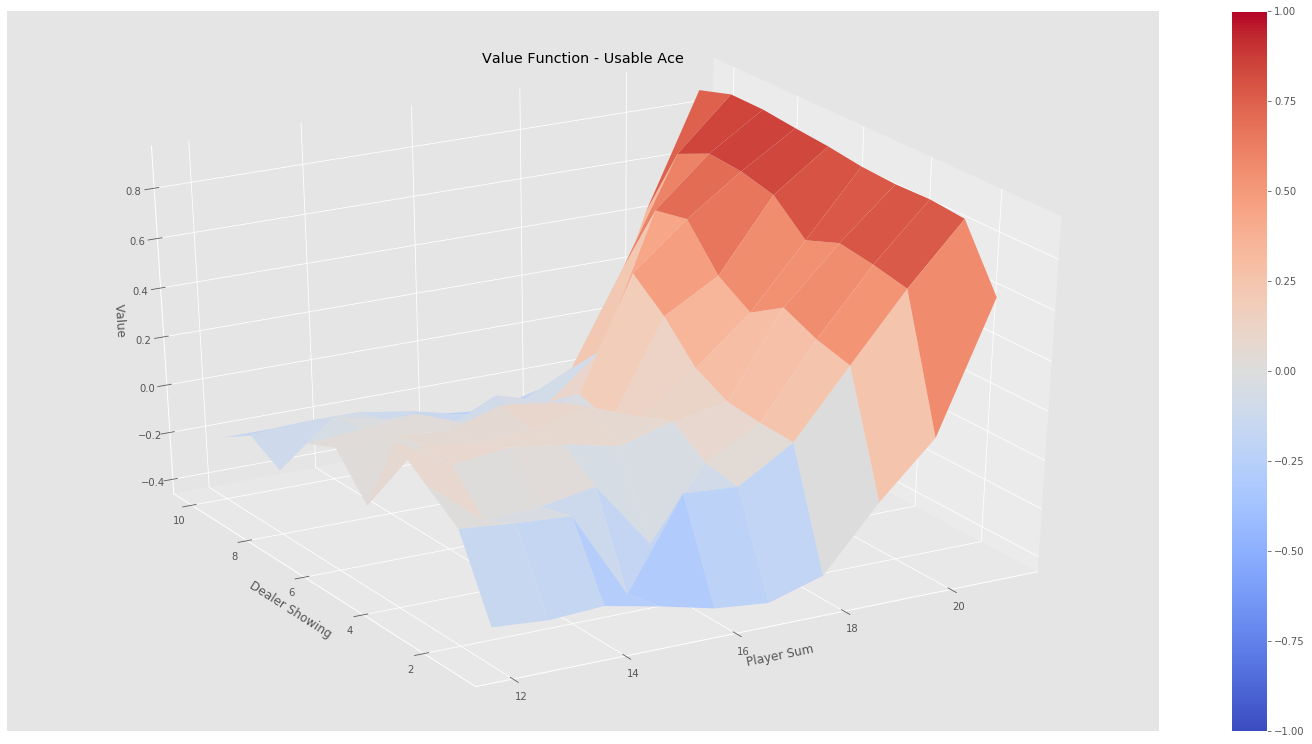

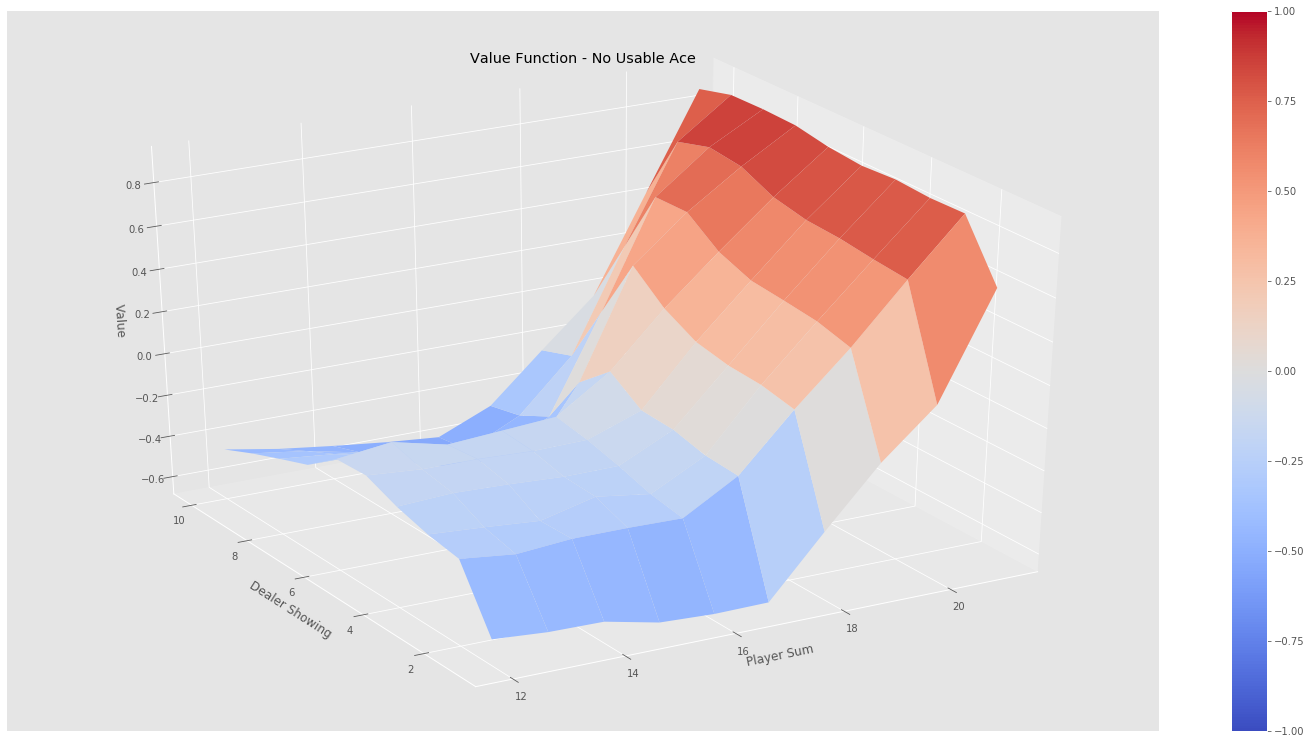

In [13]:
def plot_surface(X, Y, Z, title):
    """Plot a 3d surface.

    Args:
        X: 2-d numpy.array indicating X positions (first input to the 3-d curve).
        Y: 2-d numpy.array indicating Y positions (second input to the 3-d curve).
        Z: 2-d numpy.array indicating Z positions (value of the 3-d curve).
        title: title of the plot
    """
    fig = plt.figure(figsize=(20, 10))
    ax = Axes3D(fig)
    surf = ax.plot_surface(
        X,
        Y,
        Z,
        rstride=1,
        cstride=1,
        cmap=matplotlib.cm.coolwarm,
        vmin=-1.0,
        vmax=1.0,
    )
    ax.set_xlabel('Player Sum')
    ax.set_ylabel('Dealer Showing')
    ax.set_zlabel('Value')
    ax.set_title(title)
    ax.view_init(ax.elev, -120)
    fig.colorbar(surf)
    plt.show()


num_episodes = 500_000

# YOUR CODE HERE
num_runs = 1
for i in tqdm.tnrange(num_runs, desc='Runs'):
    eps = 0.1
    gamma = 1.0
    (Q, returns) = on_policy_every_visit_mc_control(env_blackjack, num_episodes, eps=eps, gamma=gamma)


# Limit the ranges like in the book
X_1 = np.arange(12, 22)
Y_1 = np.arange(1, 11)
Xi, Yi = np.meshgrid(X_1, Y_1)
Zi = np.zeros(shape=(len(X_1), len(Y_1)))

for i in range(len(X_1)):
    for j in range(len(Y_1)):
        state = (X_1[i], Y_1[j], True)
        if state in Q.keys():
            Zi[i][j] = np.max(Q.get(state))
plot_surface(np.transpose(Xi), np.transpose(Yi), Zi, "Value Function - Usable Ace")


for i in range(len(X_1)):
    for j in range(len(Y_1)):
        state = (X_1[i], Y_1[j], False)
        if state in Q.keys():
            Zi[i][j] = np.max(Q.get(state))
plot_surface(np.transpose(Xi), np.transpose(Yi), Zi, "Value Function - No Usable Ace")


### Exercise 5 (10 pts):

Implement the below function to train an off-policy every-visit MC agent which uses weighted importance sampling. As before, the behavior policy should be the epsilon greedy action selection.

In [14]:
def off_policy_every_visit_is_control(env, num_episodes, *, eps, gamma):
    '''
    Trains an off-policy every-visit MC agent with weighted importance sampling.
    
    Args:
        env: The environment to train the agent on.
        num_episodes: The number of episodes for which to train the agent.
        eps: The probability to select a random action. Float between 0 and 1.      
        gamma: The discount factor.
        
    Returns:
        Q is a dictionary mapping state -> action values array.
        returns is a list containing the rewards obtained for each episode during training.
    '''
    
    # Create Q function dict with default values, and C (the counts) dict with default values
    Q = defaultdict(lambda: np.zeros([env.action_space.n]))
    C = defaultdict(lambda: np.zeros([env.action_space.n], dtype=np.int))
    policy = defaultdict(int)
    
    G_queue = deque(maxlen=100)  # stores 100 most recent episode returns for diagnostics
    
    # Returns array to store episode performances
    returns = np.empty(num_episodes)

    pbar = tqdm.tnrange(num_episodes, leave=False)
    for i in pbar:       
        # YOUR CODE HERE:  sample an episode using the epsilon-greedy policy,
        # and use the transition list to compute returns and update Q and C.
        episode = sample_episode(env, Q, eps=eps)
        T = len(episode)
        
        G = 0.0
        W = 1
        
        Q_behavior = copy.deepcopy(Q)
        for step in reversed(range(T)):
            
            (state, action, reward) = episode[step]
            G = gamma * G + reward
                                              
            # Update C
            C[state][action] += W
        
            # Update Q
            old_Q = Q[state][action]
            Q[state][action] = old_Q + W / C[state][action] * (G - old_Q)
            
            # Update policy
            policy[state] = np.argmax(Q[state])
            
            # Exit loop when A_t different policy(state)
            if (action != policy[state]):
                break
            else:
                # Caclulate b(At|St)              
                behavior_greedy_action = np.argmax(Q_behavior[state])
                
                if (action != behavior_greedy_action):
                    b_At_St = eps / env.action_space.n
                else:
                    b_At_St = 1 - eps + eps / env.action_space.n
                
                # Update W
                W = W * 1 / b_At_St
            
        returns[i] = G        
        # diagnostics
        G_queue.append(G)
        pbar.set_description(f'Episodes G={sum(G_queue) / len(G_queue)}')
            
    return Q, returns

### Exercise 6 (20 pts):

a) (5pts) Compute and plot the learning curve weighted importance sampling in the blackjack environment, averaging 50 runs of 5k episodes each.  Again, start with $\epsilon = 0.5$, and use the resulting plots to find a better $\epsilon$ with better convergence.  Compare the results to those shown in exercise (3c).

/home/hainh22/rl_hw_4/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/hainh22/rl_hw_4/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


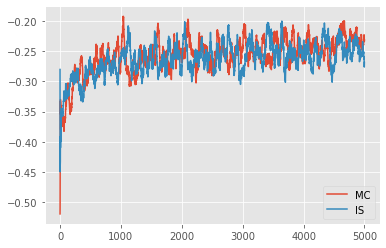

In [15]:
num_runs, num_episodes = 50, 5_000

returns_mc = np.empty((num_runs, num_episodes))
returns_is = np.empty((num_runs, num_episodes))

eps = 0.5

for i in tqdm.tnrange(num_runs, desc='Runs (MC)'):
    # YOUR CODE HERE
    learning_curve = returns_mc.mean(axis=0)  
    (_, temp) = on_policy_every_visit_mc_control(env_blackjack, num_episodes, eps=eps, gamma=1.0)
    returns_mc[i] = temp
learning_curve_mc = returns_mc.mean(axis=0)

for i in tqdm.tnrange(num_runs, desc='Runs (IS)'):
    # YOUR CODE HERE
    (_, temp) = off_policy_every_visit_is_control(env_blackjack, num_episodes, eps=eps, gamma=1.0)
    returns_is[i] = temp
learning_curve_is = returns_is.mean(axis=0)

# Plot MC
smooth_data_mc = rolling_average(learning_curve_mc, window_size = 50)
plt.plot(smooth_data_mc, label='MC')

# Plot IS
smooth_data_is = rolling_average(learning_curve_is, window_size = 50)
plt.plot(smooth_data_is, label='IS')

# Legend
plt.legend()

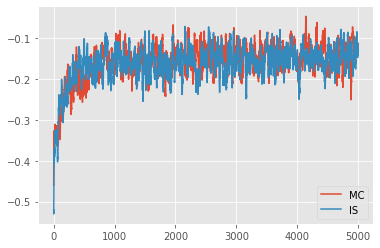

In [16]:
# YOUR CODE HERE
num_runs, num_episodes = 50, 5_000

returns_mc = np.empty((num_runs, num_episodes))
returns_is = np.empty((num_runs, num_episodes))

eps = 0.01

for i in tqdm.tnrange(num_runs, desc='Runs (MC)'):
    # YOUR CODE HERE
    learning_curve = returns_mc.mean(axis=0)  
    (_, temp) = on_policy_every_visit_mc_control(env_blackjack, num_episodes, eps=eps, gamma=1.0)
    returns_mc[i] = temp
learning_curve_mc = returns_mc.mean(axis=0)

for i in tqdm.tnrange(num_runs, desc='Runs (IS)'):
    # YOUR CODE HERE
    (_, temp) = off_policy_every_visit_is_control(env_blackjack, num_episodes, eps=eps, gamma=1.0)
    returns_is[i] = temp
learning_curve_is = returns_is.mean(axis=0)

# Plot MC
smooth_data_mc = rolling_average(learning_curve_mc, window_size = 20)
plt.plot(smooth_data_mc, label='MC')

# Plot IS
smooth_data_is = rolling_average(learning_curve_is, window_size = 20)
plt.plot(smooth_data_is, label='IS')

# Legend
plt.legend()

b) (5 pts) Now implement Monte Carlo Evaluation for the greddy policy of a Q function.

In [17]:
def on_policy_mc_evaluation(env, Q, num_episodes, *, gamma):
    '''
    Monte Carlo policy Evaluation.
    
    Args:
        env: The environment to train the agent on.
        Q is a dictionary mapping state -> action values array.
        num_episodes: The number of episodes for which to evaluate the agent.
        gamma: The discount factor.
        
    Returns:
        returns is a list containing the rewards obtained for each episode.
    '''
    returns = np.empty(num_episodes)
    
    pbar = tqdm.tnrange(num_episodes, leave=False)
    for i in pbar:
        # YOUR CODE HERE:  sample an episode using the epsilon-greedy policy,
        # and use the transition list to compute returns and update Q and C.
        episode = sample_episode(env, Q, eps=0)
        T = len(episode)
        
        G = 0.0
              
        for step in reversed(range(T)):          
            (state, action, reward) = episode[step]
            G = gamma * G + reward                                                       
            
        returns[i] = G
        
        pbar.set_description(f'Episodes G={G}')
            
    return returns

c) (5 pts) Now run off-policy every-visit Importance Sampling control for 50 runs and 10k episodes, with $\epsilon = 0.1$, and plot the returns as you did previously.  Then, evaluate the Q function obtained by one of the 50 runs using the on-policy evaluation function, and print the resulting returns' mean and standard deviation.


-0.15697600000000003 0.1380283138490071


-0.1103 0.9507543899451635


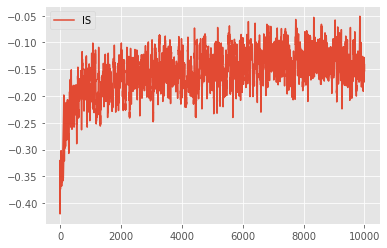

In [18]:
num_runs, num_episodes = 50, 10_000

returns_is = np.empty((num_runs, num_episodes))
for i in tqdm.tnrange(num_runs, desc='Runs (IS)'):
    # YOUR CODE HERE
    eps = 0.1
    (Q, temp) = off_policy_every_visit_is_control(env_blackjack, num_episodes, eps=eps, gamma=1.0)
    returns_is[i] = temp
learning_curve_is = returns_is.mean(axis=0)

# Plot IS
smooth_data_is = rolling_average(learning_curve_is, window_size = 20)
plt.plot(smooth_data_is, label='IS')
plt.legend()
    
# YOUR CODE HERE
# Previous mean and std
print(np.mean(learning_curve_is), np.std(learning_curve_is))

# Evaluate the Q-function from one run
returns = on_policy_mc_evaluation(env_blackjack, Q, num_episodes, gamma = 1.0)
print(np.mean(returns), np.std(returns))